# Analyzing Fitbit-data in R
This notebook requires you to use the [*Fitbit* connection](https://www.openhumans.org/activity/fitbit-connection/) to get your activity data into Open Humans. 

Given that the imported Fitbit data has a rather particular *JSON* format this notebook just gives an idea of how to extract individual data from the larger data set.

For a start let's load our required packages. To load the *JSON* we are using `rjson`, which needs to be installed with `install.packages` in the first step:

In [3]:
install.packages('rjson')
library(httr)
library("rjson")
library(jsonlite)
library(ggplot2)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Attaching package: ‘rjson’

The following objects are masked from ‘package:jsonlite’:

    fromJSON, toJSON



With that out of the way we can find the *Fitbit* data from our Open Humans account:

In [4]:
access_token <- Sys.getenv("OH_ACCESS_TOKEN")
url <- paste("https://www.openhumans.org/api/direct-sharing/project/exchange-member/?access_token=",access_token,sep="")
resp <- GET(url)
user <- content(resp, "parsed")

for (data_source in user$data){
    if (data_source$source == "direct-sharing-102"){
         fitbit_url <- data_source$download_url
    }
}

temp <- tempfile()
download.file(fitbit_url,temp,method='wget')
json_data <- fromJSON(file=temp)

Now that we have our fitbit data stored in `json_data` we can start to extract individual data types from it. 

Let's focus on `steps` for now. We create two empty vectors and from there we first iterate over the `yearly_entry` in `json_data$'tracker-steps'`. Each `yearly_entry` has one main list, which is `activities-tracker-steps`. Which is why we now can iterate over `yearly_entry$'activities-tracker-steps'` and get the `dateTime` and `value` for each of these `entry`. 

**This is not how you should do things in `R`, but I couldn't find out a better way to extract that data. If you do: Please be in touch at bastian@openhumans.org!**

In [5]:

dates <- c()
steps <- c()

for (yearly_entry in json_data$'tracker-steps'){
    for (entry in yearly_entry$'activities-tracker-steps'){
    dates <- append(dates,entry$dateTime)
    steps <- append(steps,entry$value)
    }
}

Once that's done we can merge the `dates` and `steps` into a single data frame and convert the data types:

In [6]:
df <- data.frame('date' = dates, 'steps' = steps)
df$steps <- as.numeric(as.character(df$steps))
df$date <- as.Date(as.character(df$date))
df$year <- as.character(format(df$date,"%Y"))

Now we can start our first plot: All of our daily steps

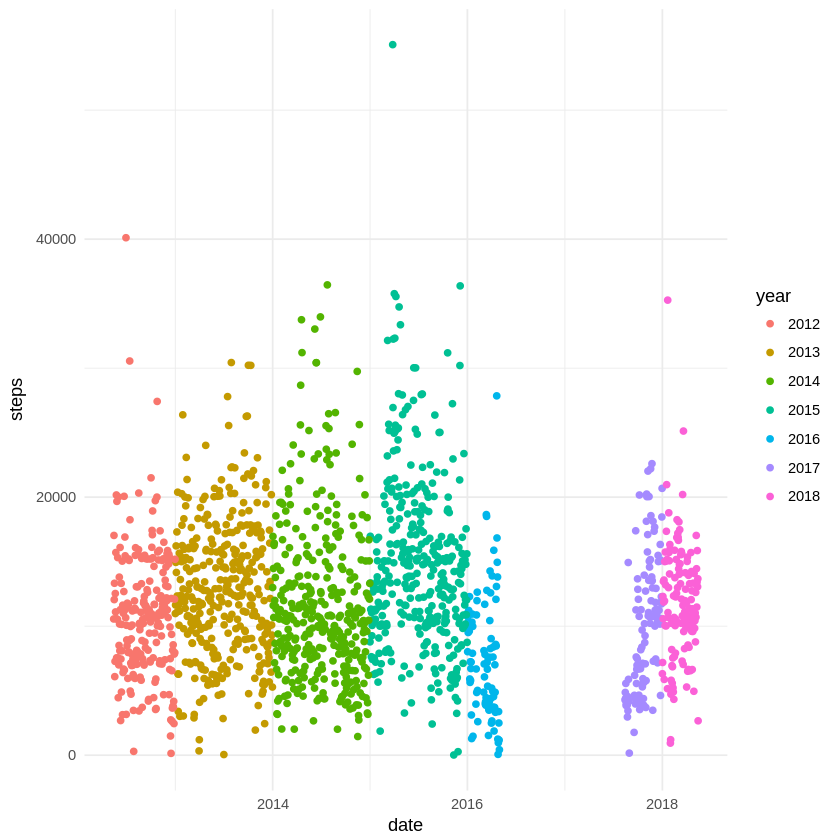

In [7]:
ggplot(subset(df,df$steps != 0),aes(date,steps,color=year)) + geom_point() + theme_minimal()

Let's now also compare the daily step counts between the years. For this we generate `fake_date`s, which contain only the real `day` and `month` but are all normalized onto the same `year`. With that we can now plot everything onto a single `x-axis` by using the `fake_date` for it and still keep the `year`, using the variable of the same name:

`geom_smooth()` using method = 'loess'


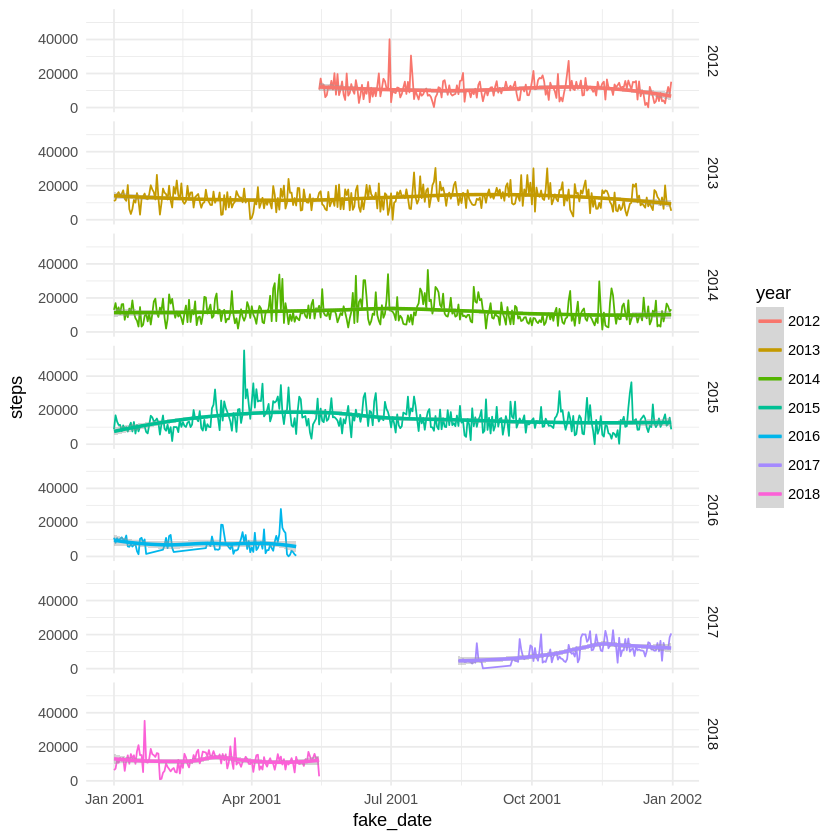

In [8]:
df$date_wo_year <- as.character(format(as.Date(df$date),"%m-%d"))
df$fake_date <- as.Date(paste('2001',df$date_wo_year,sep='-'))

ggplot(subset(df,df$steps != 0),aes(fake_date,steps,color=year)) + geom_line() + stat_smooth() + facet_grid(year ~ .) + theme_minimal()

This should give you an idea of how to read the Fitbit data. To see all the different data types that are in the fitbit data you can use the following:

In [9]:
names(json_data)

[1] "activities-overview"            "tracker-minutes-very-active"   
 [3] "minutes-to-sleep"               "awake-minutes"                 
 [5] "sleep-efficiency"               "sleep-awakenings"              
 [7] "heart"                          "tracker-minutes-fairly-active" 
 [9] "sleep-minutes-after-wakeup"     "tracker-minutes-lightly-active"
[11] "sleep-minutes"                  "tracker-steps"                 
[13] "weight"                         "tracker-activity-calories"     
[15] "tracker-elevation"              "tracker-calories"              
[17] "tracker-minutes-sedentary"      "tracker-distance"              
[19] "time-in-bed"                    "weight-log"                    
[21] "tracker-floors"                 "profile"                       
[23] "sleep-start-time"

And with that happy exploring!